<a href="https://colab.research.google.com/github/alishafique3/Efficient-Machine-Learning_Optimizations-and-Benchmarking/blob/main/Fire_Classification_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fire and Smoke Detection Using CNN
This project is developed using Blog at Pyimagesearch https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/
by Adrian Rosebrock on November 18, 2019

It has been modified and updated by me at 28-March-2020


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Libraries and Neural Network Model Class

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0
/device:GPU:0


In [3]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

##Import Data from Google Drive

In [4]:

# initialize the path to the fire and non-fire dataset directories
FIRE_PATH = '/content/drive/My Drive/Colab Notebooks/Robbery_Accident_Fire_Database2/Fire'
NON_FIRE_PATH = '/content/drive/My Drive/Colab Notebooks/spatial_envelope_256x256_static_8outdoorcategories'

# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

# define batch size, and number of epochs
BATCH_SIZE = 64
NUM_EPOCHS = 50

SAMPLE_SIZE = 50

In [5]:

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

		# add the image to the data lists
		data.append(image)

	# return the data list as a NumPy array
	return np.array(data, dtype="float32")

# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset( FIRE_PATH)
nonFireData = load_dataset( NON_FIRE_PATH)
print("[INFO] Completed")

[INFO] loading data...
[INFO] Completed


##Preprocessing and Exploring Dataset

In [46]:
print(fireData.shape)
print(nonFireData.shape)

(1315, 128, 128, 3)
(2693, 128, 128, 3)


In [47]:
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])


In [48]:
data /= 255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)


In [49]:
print(data.shape)
print(labels.shape)
print(labels[1:])
print(classTotals)

(4008, 128, 128, 3)
(4008, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[2693. 1315.]


In [50]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size= TEST_SPLIT, random_state=42)

In [51]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3006, 128, 128, 3)
(3006, 2)
(1002, 128, 128, 3)
(1002, 2)


##Training Model

In [62]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
#opt = 'adam'
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_12 (Separa  (None, 128, 128, 16)     211       
 bleConv2D)                                                      
                                                                 
 activation_21 (Activation)  (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 separable_conv2d_13 (Separa  (None, 64, 64, 32)       688       
 bleConv2D)                                           

In [64]:
# train the network
print("[INFO] training network...")
H = model.fit(
  trainX, trainY, batch_size= BATCH_SIZE,
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] //  BATCH_SIZE,
	epochs= NUM_EPOCHS,
	verbose=1)


[INFO] training network...
Epoch 1/50
46/46 [==============================] - 8s 59ms/step - loss: 0.7765 - accuracy: 0.6814 - val_loss: 0.6514 - val_accuracy: 0.6507
Epoch 2/50
46/46 [==============================] - 2s 44ms/step - loss: 0.5949 - accuracy: 0.7750 - val_loss: 0.6824 - val_accuracy: 0.6507
Epoch 3/50
46/46 [==============================] - 2s 41ms/step - loss: 0.5134 - accuracy: 0.8073 - val_loss: 0.7292 - val_accuracy: 0.6507
Epoch 4/50
46/46 [==============================] - 2s 40ms/step - loss: 0.4411 - accuracy: 0.8389 - val_loss: 0.8472 - val_accuracy: 0.6507
Epoch 5/50
46/46 [==============================] - 2s 41ms/step - loss: 0.3835 - accuracy: 0.8685 - val_loss: 0.9462 - val_accuracy: 0.6507
Epoch 6/50
46/46 [==============================] - 2s 41ms/step - loss: 0.3309 - accuracy: 0.8963 - val_loss: 1.1695 - val_accuracy: 0.6507
Epoch 7/50
46/46 [==============================] - 2s 39ms/step - loss: 0.2972 - accuracy: 0.9048 - val_loss: 1.4234 - val_acc

##Exploring Predictions

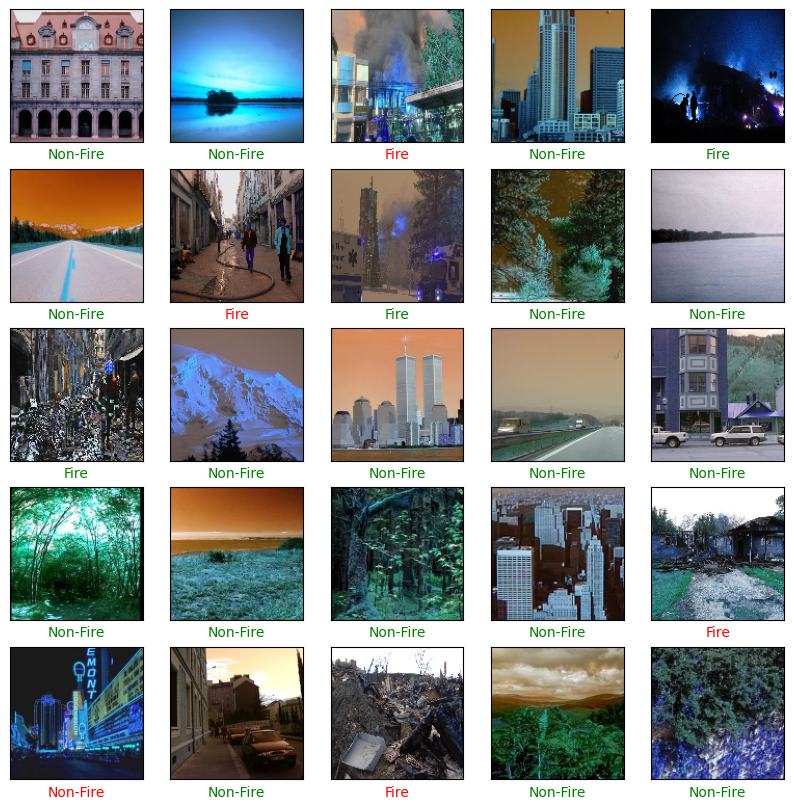

In [65]:
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i], cmap=plt.cm.binary)
    if testY[i][0] == 1:
      if predictions[i][0] > 0.5:
        plt.xlabel("Non-Fire", color='green')
      else:
        plt.xlabel("Non-Fire", color='red')
    else:
      if predictions[i][1] > 0.5:
        plt.xlabel("Fire", color='green')
      else:
        plt.xlabel("Fire", color='red')

plt.show()

In [72]:
import tempfile
import os


In [73]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


In [74]:
converter1 = tf.lite.TFLiteConverter.from_keras_model(model)
baseline_tflite_model = converter1.convert()

_, baseline_tflite_file = tempfile.mkstemp('.tflite')

with open(baseline_tflite_file, 'wb') as f:
  f.write(baseline_tflite_model)

print('Saved baseline TFLite model to:', baseline_tflite_file)

Saved baseline TFLite model to: /tmp/tmp21jyvpb6.tflite


In [75]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter2.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_tflite_file, 'wb') as f:
  f.write(quantized_tflite_model)

print('Saved dyanmic range quantization TFLite model to:', quantized_tflite_file)



Saved dyanmic range quantization TFLite model to: /tmp/tmpc091kljh.tflite


In [76]:
converter3 = tf.lite.TFLiteConverter.from_keras_model(model)
converter3.optimizations = [tf.lite.Optimize.DEFAULT]
converter3.target_spec.supported_types = [tf.float16]
fquantized_tflite_model = converter3.convert()

_, fquantized_tflite_file = tempfile.mkstemp('.tflite')

with open(fquantized_tflite_file, 'wb') as f:
  f.write(fquantized_tflite_model)

print('Saved float16 quantization TFLite model to:', fquantized_tflite_file)

Saved float16 quantization TFLite model to: /tmp/tmppibnalvd.tflite


In [77]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(baseline_tflite_file)))
print("Size of gzipped dynamic quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_tflite_file)))
print("Size of gzipped Float16 quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(fquantized_tflite_file)))


Size of gzipped baseline Keras model: 7828061.00 bytes
Size of gzipped dynamic quantized TFlite model: 1924370.00 bytes
Size of gzipped Float16 quantized TFlite model: 3848743.00 bytes
